In [1]:
%pylab

Using matplotlib backend: TkAgg
Populating the interactive namespace from numpy and matplotlib


In [2]:
%matplotlib inline

In [4]:
import pystan, pickle

# models 

## bayesian 

In [5]:
sim_gp = pickle.load(open('sim_gp_simple.pkl', 'rb'))
sim_gp

<pystan.model.StanModel instance at 0x7fada0607cf8>

In [ ]:
train_gp = pystan.StanModel('gp_simple_latent.stan')

pickle.dump(train_gp, open('train_gp.pkl', 'wb'))

In [ ]:
train_gp = pickle.load(open('train_gp.pkl', 'rb'))
train_gp

## marginalized 

In [ ]:
marginal_gp = pystan.StanModel('gp_marginal.stan')

pickle.dump(marginal_gp, open('marginal_gp.pkl', 'wb'))

In [ ]:
marginal_gp_sim = pystan.StanModel('gp_marginal_sim.stan')

pickle.dump(marginal_gp_sim, open('marginal_gp_sim.pkl', 'wb'))

# simulations 

In [215]:
sim_data = {
    'N': 1000,
    'length_scale': 0.18,
    'alpha': 1,
    'sigma': .32
}

In [175]:
# sample = sim_gp.sampling(algorithm='Fixed_param', iter=1, chains=1, seed=363360090, data=sim_data).extract()
sample = sim_gp.sampling(algorithm='Fixed_param', iter=1, chains=1, data=sim_data).extract()

In [176]:
x, y, f = sample['x'][0,:], sample['y'][0,:], sample['f'][0,:]

ind = np.argsort(x)

x = x[ind]
y = y[ind]
f = f[ind]

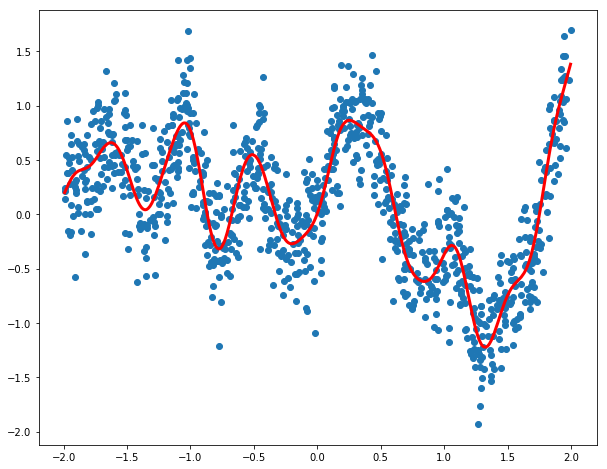

In [177]:
plt.figure(figsize=(10,8))
plt.scatter(x, y);

plt.plot(x,f, c='r', lw=3);

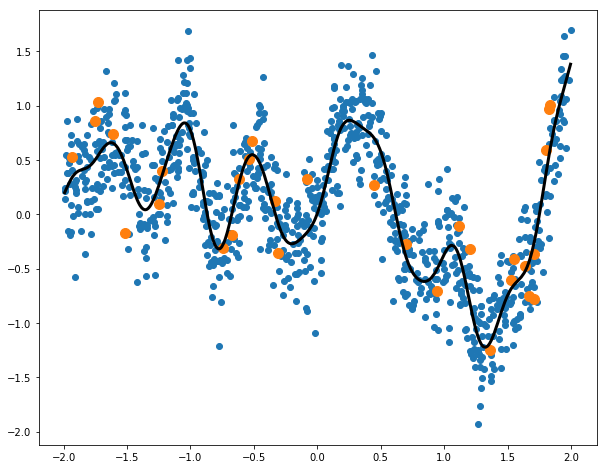

In [178]:
train_ind = np.random.choice(np.arange(sim_data['N']), size=30, replace=False)
test_ind = [i for i in np.arange(sim_data['N']) if i not in train_ind ]

train_ind.sort()
test_ind.sort()

plt.figure(figsize=(10,8))
plt.scatter(x[test_ind], y[test_ind]);
plt.scatter(x[train_ind], y[train_ind],s=100);
plt.plot(x,f, c='k', lw=3);

In [179]:
train_data = {
    'N':len(train_ind),
    'N_pred': len(test_ind),
    'x': x[train_ind],
    'y': y[train_ind],
    'x_pred': x[test_ind]
}

In [180]:
tsamples = train_gp.sampling(data=train_data,chains=4, iter=2000, control = {'adapt_delta': 0.95})

In [181]:
print tsamples

Inference for Stan model: anon_model_36f78da3c320c35d439945bfc9cbb0e3.
4 chains, each with iter=2000; warmup=1000; thin=1; 
post-warmup draws per chain=1000, total post-warmup draws=4000.

               mean se_mean     sd   2.5%    25%    50%    75%  97.5%  n_eff   Rhat
length_scale   0.11  1.1e-3   0.03   0.07   0.09   0.11   0.12   0.16  581.0    1.0
alpha          0.64  4.8e-3   0.14   0.42   0.54   0.63   0.72   0.98  875.0    1.0
sigma          0.19  2.6e-3   0.06   0.11   0.15   0.18   0.21   0.33  492.0    1.0
f_eta[0]       0.78  5.4e-3   0.34   0.19   0.56   0.76   0.97   1.53 4000.0    1.0
f_eta[1]       1.29  9.2e-3   0.37   0.65   1.03   1.26   1.52   2.07 1635.0    1.0
f_eta[2]       0.78    0.01   0.72  -0.64   0.29   0.78   1.25    2.2 4000.0    1.0
f_eta[3]      -0.03    0.02   0.72  -1.46  -0.52  -0.03   0.47   1.33 1860.0    1.0
f_eta[4]      -0.74    0.01   0.68  -2.13  -1.16  -0.72  -0.32   0.61 3572.0    1.0
f_eta[5]       0.41  5.5e-3    0.3  -0.15   0.21   0.39

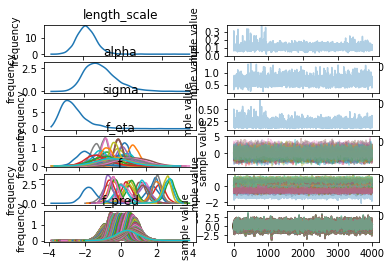

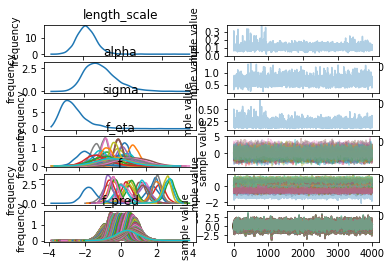

In [182]:
tsamples.plot()

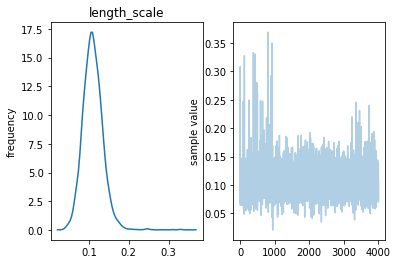

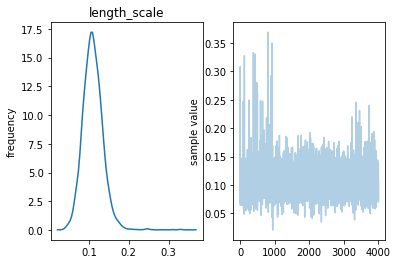

In [183]:
tsamples.plot(['length_scale'])

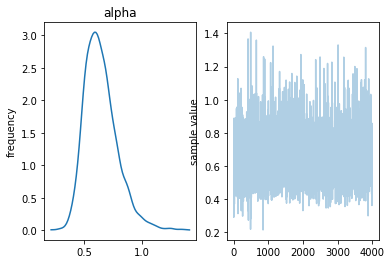

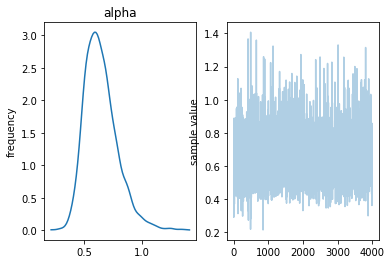

In [184]:
tsamples.plot(['alpha'])

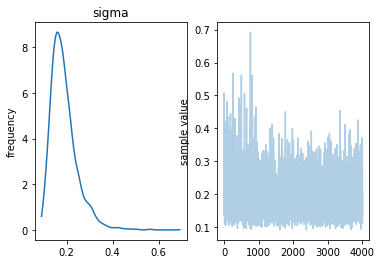

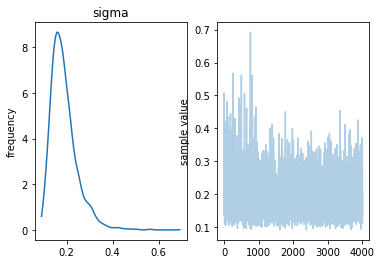

In [185]:
tsamples.plot(['sigma'])

In [186]:
tsamp = tsamples.extract(permuted=True)

In [201]:
tsamp.keys()

[u'length_scale', u'alpha', u'sigma', u'f_eta', u'f', u'f_pred', u'lp__']

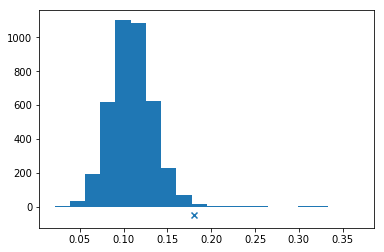

In [207]:
plt.hist(tsamp['length_scale'],20);
plt.scatter([sim_data['length_scale']], [-50], marker='x')

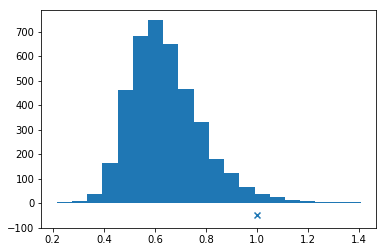

In [208]:
plt.hist(tsamp['alpha'],20);
plt.scatter([sim_data['alpha']], [-50], marker='x')

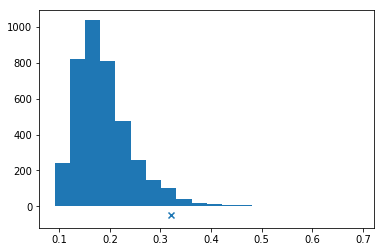

In [209]:
plt.hist(tsamp['sigma'],20);
plt.scatter([sim_data['sigma']], [-50], marker='x')

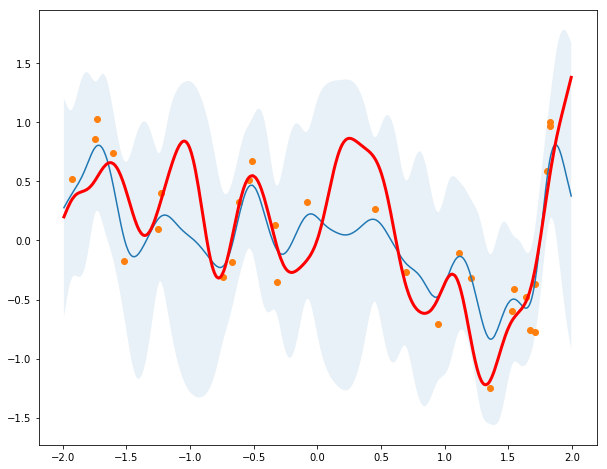

In [210]:
plt.figure(figsize=(10,8))

# plt.plot(x[test_ind],tsamp['f_pred'].T, alpha=.1,c='k');
plt.plot(x[test_ind],tsamp['f_pred'].mean(0));
plt.fill_between(x[test_ind],tsamp['f_pred'].mean(0) - 2*tsamp['f_pred'].std(0), tsamp['f_pred'].mean(0) + 2*tsamp['f_pred'].std(0), alpha=.1);

plt.plot(x[test_ind],f[test_ind],c='r',lw=3)

plt.scatter(train_data['x'], train_data['y'])

## marginal 

In [212]:
temp = marginal_gp.sampling(iter=1,chains=1, algorithm='Fixed_param', data=marginal_gp_data)

In [214]:
temp.extract()

OrderedDict([(u'length_scale', array(5.493305644753268)),
             (u'alpha', array(1.262461342600496)),
             (u'sigma', array(0.18345077301691137)),
             (u'lp__', array(0.0))])

In [189]:
opt = marginal_gp.optimizing(data=train_data)

In [190]:
opt.keys()

[u'length_scale', u'alpha', u'sigma']

In [191]:
opt

OrderedDict([(u'length_scale', array(0.1008934682412954)),
             (u'alpha', array(0.5909400922718592)),
             (u'sigma', array(0.15834575319356248))])

In [192]:
marginal_gp_data = train_data.copy()

for k in opt.keys():
    marginal_gp_data[k] = opt[k]

marginal_gp_data.keys()

['x_pred', 'N_pred', 'N', u'length_scale', u'alpha', 'y', 'x', u'sigma']

In [193]:
marge_draws = marginal_gp_sim.sampling(iter=1,algorithm='Fixed_param',
                 chains = 1,data = marginal_gp_data)

In [194]:
marginal_fpred = marge_draws.extract()['f_pred']

In [195]:
marginal_fpred.shape

(1, 2, 970)

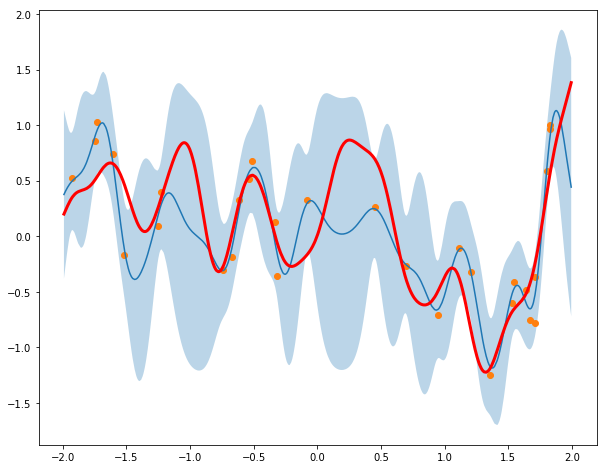

In [196]:
plt.figure(figsize=(10,8))

plt.plot(marginal_gp_data['x_pred'], marginal_fpred[0,0,:]);

plt.fill_between(marginal_gp_data['x_pred'], marginal_fpred[0,0,:]-2*marginal_fpred[0,1,:], marginal_fpred[0,0,:]+2*marginal_fpred[0,1,:], alpha=.3);

plt.plot(x[test_ind],f[test_ind],c='r',lw=3)

plt.scatter(marginal_gp_data['x'], marginal_gp_data['y'])